# GAN's From Scratch 

by Kris Smith

# Problem Statement

***This notebook is working towards generating images in the style of a famous artist painter [Claude Monet](https://en.wikipedia.org/wiki/Claude_Monet). This problem is presented as a competition on the Kaggle platform for the sake of learning. We will explore in particular one common approach to this task in the form of [Generative Adversarial Networks(GANs)](https://en.wikipedia.org/wiki/Generative_adversarial_network).***

In [7]:
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# import tensorflow_addons as tfa

from kaggle_datasets import KaggleDatasets
# import matplotlib.pyplot as plt
# import numpy as np

# try:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
#     print('Device:', tpu.master())
#     tf.config.experimental_connect_to_cluster(tpu)
#     tf.tpu.experimental.initialize_tpu_system(tpu)
#     strategy = tf.distribute.experimental.TPUStrategy(tpu)
# except:
#     strategy = tf.distribute.get_strategy()
# print('Number of replicas:', strategy.num_replicas_in_sync)

# AUTOTUNE = tf.data.experimental.AUTOTUNE
    
# print(tf.__version__)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
# import gdown
from zipfile import ZipFile

import os
import math
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import albumentations as A

# Overview

### Dataset Description
<i>The dataset contains four directories: monet_tfrec, photo_tfrec, monet_jpg, and photo_jpg. The monet_tfrec and monet_jpg directories contain the same painting images, and the photo_tfrec and photo_jpg directories contain the same photos.<i>

<i>We recommend using TFRecords as a Getting Started competition is a great way to become more familiar with a new data format, but JPEG images have also been provided.

<i>The monet directories contain Monet paintings. Use these images to train your model.

<i>The photo directories contain photos. Add Monet-style to these images and submit your generated jpeg images as a zip file. Other photos outside of this dataset can be transformed but keep your submission file limited to 10,000 images.

<i>Note: Monet-style art can be created from scratch using other GAN architectures like DCGAN. The submitted image files do not necessarily have to be transformed photos.

<i>Check out the CycleGAN dataset to experiment with the artistic style of other artists.</i>

    
### Files
* monet_jpg - 300 Monet paintings sized 256x256 in JPEG format
* monet_tfrec - 300 Monet paintings sized 256x256 in TFRecord format
* photo_jpg - 7028 photos sized 256x256 in JPEG format
* photo_tfrec - 7028 photos sized 256x256 in TFRecord format

### Submission format
* Your kernel's output must be called images.zip and contain 7,000-10,000 images sized 256x256.
    
    
### Evaluation
    
MiFID
    
Submissions are evaluated on MiFID (Memorization-informed Fréchet Inception Distance), which is a modification from Fréchet Inception Distance (FID).

The smaller MiFID is, the better your generated images are.

What is FID?
Originally published here (github), FID, along with Inception Score (IS), are both commonly used in recent publications as the standard for evaluation methods of GANs.

In FID, we use the Inception network to extract features from an intermediate layer. Then we model the data distribution for these features using a multivariate Gaussian distribution with mean µ and covariance Σ. The FID between the real images 𝑟
 and generated images 𝑔
 is computed as:
$$
FID = ||\mu_{r} - \mu_{g}||^{2} + Tr(\Sigma_{r} + \Sigma_{g} - 2(\Sigma_{r}\Sigma_{g})^{1/2})
$$

    
    where 𝑇𝑟 sums up all the diagonal elements. FID is calculated by computing the Fréchet distance between two Gaussians fitted to feature representations of the Inception network.

What is MiFID (Memorization-informed FID)?
In addition to FID, Kaggle takes training sample memorization into account.

The memorization distance is defined as the minimum cosine distance of all training samples in the feature space, averaged across all user generated image samples. This distance is thresholded, and it's assigned to 1.0 if the distance exceeds a pre-defined epsilon.

In mathematical form:
    
$$
d_{ij} = 1 - \cos(f_{gi}, f_{rj}) = 1 - \frac{f_{gi} \cdot f_{rj}}{||f_{gi}|| ||f_{rj}||}
$$
    
where 𝑓𝑔
 and 𝑓𝑟
 represent the generated/real images in feature space (defined in pre-trained networks); and 𝑓𝑔𝑖
 and 𝑓𝑟𝑗
 represent the 𝑖𝑡ℎ
 and 𝑗𝑡ℎ
 vectors of 𝑓𝑔
 and 𝑓𝑟
, respectively.

$$
d = \frac{1}{N} \sum_{i} \min_{j} d_{ij}
$$
    
defines the minimum distance of a certain generated image (𝑖
) across all real images ((𝑗
), then averaged across all the generated images.

enter image description here
defines the threshold of the weight only applies when the (𝑑
) is below a certain empirically determined threshold.

Finally, this memorization term is applied to the FID:
    
$$
MiFID = FID * \frac{1}{d_thr}
$$
    
**Kaggle's workflow calculating MiFID for public and private scores**
    
Kaggle calculates public MiFID scores with the pre-train neural network Inception, and the public images used for evaluation are the rest of the TFDS Monet paintings. ***Note that as a Getting Started competition there is no private leaderboard.***

    
### Submission File
    
You are going to generate 7,000-10,000 Monet-style images that are in jpg format. Their sizes should be 256x256x3 (RGB). Then you need to zip those images and your output from your Kernel should only have ONE output file named images.zip.

Please note that Kaggle Kernels has a number of output files capped at 500. We highly encourage you to either directly write to a zip file as you generate images, or create a folder at ../tmp as your temporary directory.


---

# Data

## EDA

In [8]:
BASE_PATH = "../input/gan-getting-started/"
MONET_PATH = os.path.join(BASE_PATH, "monet_jpg")
PHOTO_PATH = os.path.join(BASE_PATH, "photo_jpg")

In [9]:
def print_folder_statistics(path):
    d_image_sizes = {}
    for image_name in os.listdir(path):
        image = cv2.imread(os.path.join(path, image_name))
        d_image_sizes[image.shape] = d_image_sizes.get(image.shape, 0) + 1
        
    for size, count in d_image_sizes.items():
        print(f"shape: {size}\tcount: {count}")


print(f"Monet images:")
print_folder_statistics(MONET_PATH)
print("-" * 10)
print(f"Photo images:")
print_folder_statistics(PHOTO_PATH)
print("-" * 10)

Monet images:
shape: (256, 256, 3)	count: 300
----------
Photo images:
shape: (256, 256, 3)	count: 7038
----------


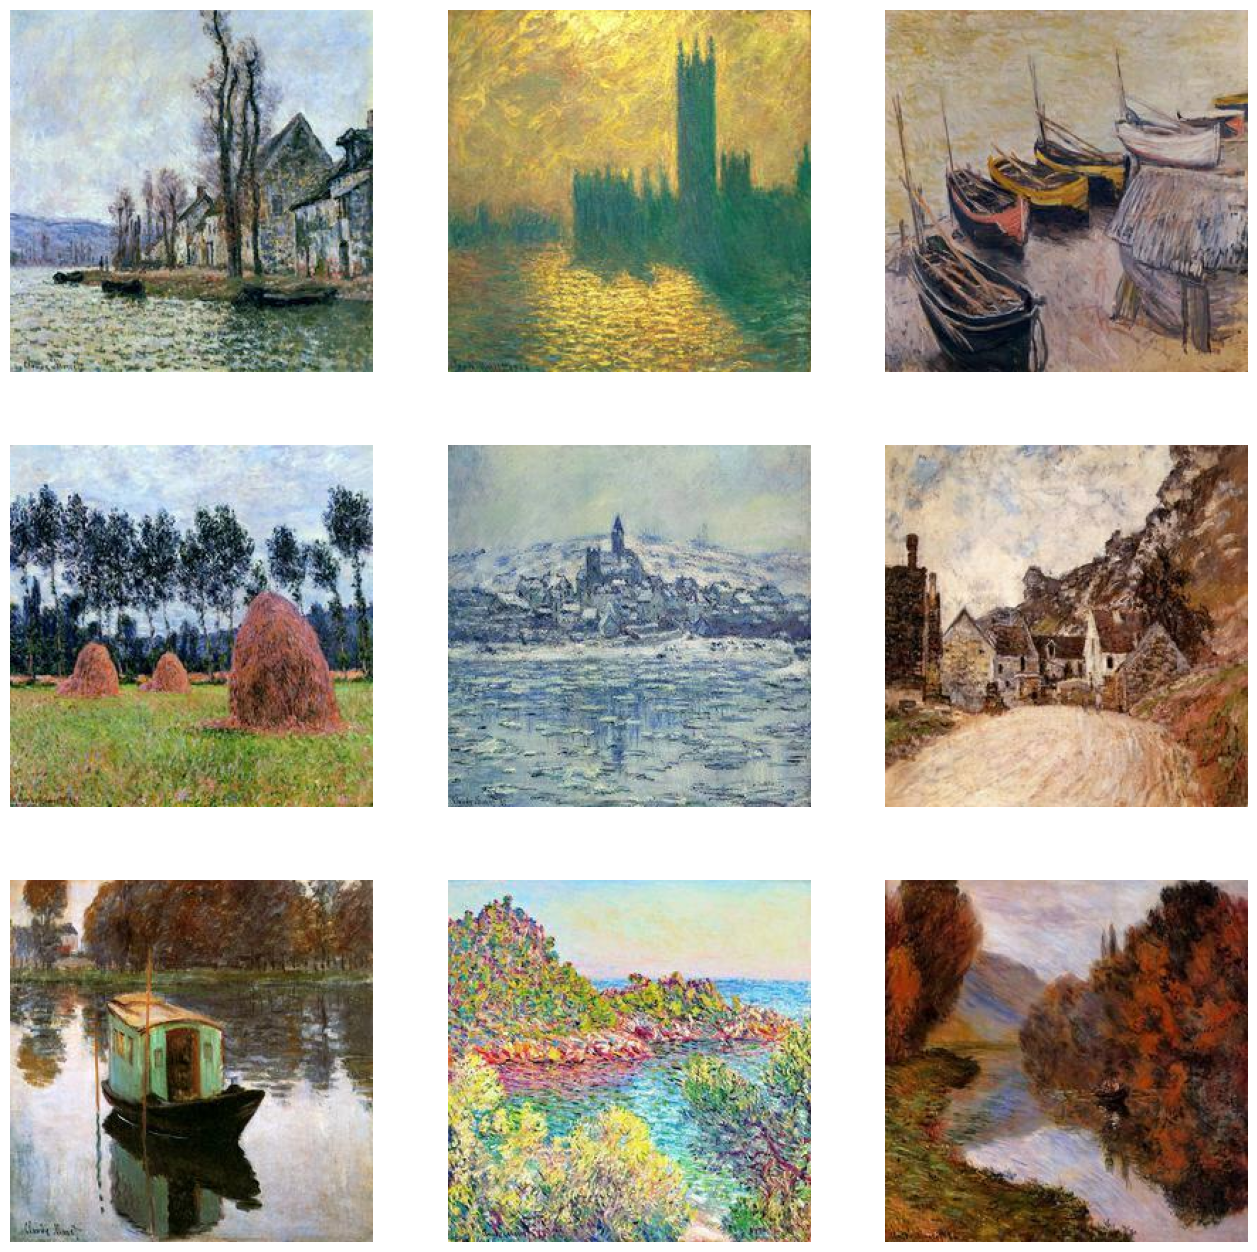

In [22]:
def batch_visualization(path, n_images, is_random=True, figsize=(16, 16)):
    plt.figure(figsize=figsize)
    
    w = int(n_images ** .5)
    h = math.ceil(n_images / w)
    
    all_names = os.listdir(path)
    
    image_names = all_names[:n_images]
    if is_random:
        image_names = random.sample(all_names, n_images)
    
    for ind, image_name in enumerate(image_names):
        img = cv2.imread(os.path.join(path, image_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
        plt.subplot(h, w, ind + 1)
        plt.imshow(img)
        plt.axis("off")
    
    plt.show()
    
batch_visualization(MONET_PATH, 9)